In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.neural_network import MLPRegressor  # veya MLPRegressor
from sklearn.metrics import classification_report, mean_squared_error, r2_score  # görevi neyse
import joblib  # model kaydetmek için
import matplotlib as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam


In [ ]:
# Define the model
model = Sequential([
    Dense(units=32, activation='relu', input_dim=57),
    Dense(units=32, activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=32, activation='relu'),

    Dense(1)
])
# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

In [4]:
data = pd.read_csv('scaled_data.csv')
data = data[:1000]
X = data.drop('popularity', axis=1)
y = data['popularity']

## Adım 1: Train-Test Split
Veriyi eğitim ve test setlerine ayırıyoruz. %80 eğitim, %20 test kullanacağız.

In [5]:
# Veriyi eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Eğitim seti boyutu: {X_train.shape}")
print(f"Test seti boyutu: {X_test.shape}")
print(f"Feature sayısı: {X_train.shape[1]}")

Eğitim seti boyutu: (800, 57)
Test seti boyutu: (200, 57)
Feature sayısı: 57


## Adım 2: Neural Network Mimarisini Oluşturma

Yapay sinir ağı modeli oluşturuyoruz:
- **Input Layer**: Feature sayısı kadar nöron 
- **Hidden Layers**: Birden fazla gizli katman (Dense layers)
- **Dropout**: Overfitting'i önlemek için
- **Output Layer**: Tek nöron (regresyon problemi)

**Aktivasyon fonksiyonları**:
- Hidden layers: ReLU (Rectified Linear Unit)
- Output layer: Linear (regresyon için)

In [6]:
mlp = MLPRegressor(random_state=42, max_iter=500)

In [7]:
param_grid = {
    'hidden_layer_sizes': [(64,), (128,), (64, 32), (128, 64), (128, 64, 32)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [1e-4, 1e-3, 1e-2],
    'learning_rate_init': [1e-3, 1e-4, 1e-2],
}

In [8]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [11]:
model = RandomizedSearchCV(
    mlp,
    param_grid,
    n_iter=20,        # kaç kombinasyon deneyeceğin
    scoring='neg_mean_squared_error',  # classification için; regresyon ise 'neg_mean_squared_error' gibi
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

## Adım 3: Model Compile ve Training

**Optimizer**: Adam - Adaptive learning rate ile hızlı öğrenme
**Loss Function**: Mean Squared Error (MSE) - Regresyon için standart
**Metrics**: MAE (Mean Absolute Error)

**Callbacks**:
- **EarlyStopping**: Validation loss iyileşmezse eğitimi durdurur
- **ReduceLROnPlateau**: Learning rate'i gerektiğinde azaltır

In [14]:
# Define Early Stopping callback
# Stops training when validation loss stops improving
early_stopping = EarlyStopping(
    monitor='val_loss',          # Metric to monitor
    patience=10,                 # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,   # Restore model weights from the epoch with the best value
    verbose=1                    # Print messages
)

# Define Learning Rate Reduction callback
# Reduces learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',          # Metric to monitor
    factor=0.5,                  # Factor by which the learning rate will be reduced (new_lr = lr * factor)
    patience=5,                  # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-7,                 # Lower bound on the learning rate
    verbose=1                    # Print messages
)

In [15]:
# Modeli eğitme
history = model.fit(
    X_train, y_train,
    validation_split=0.2,  # Eğitim setinin %20'si validation için
    epochs=200,  # Maximum epoch sayısı
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("\nEğitim tamamlandı!")

Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\USER\anaconda\envs\mlenv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


ValueError: 
All the 100 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda\envs\mlenv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda\envs\mlenv\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: BaseMultilayerPerceptron.fit() got an unexpected keyword argument 'validation_split'


## Adım 4: Model Performansını Değerlendirme

Test seti üzerinde model performansını değerlendiriyoruz.

In [ ]:
search.fit(X_train, y_train)

print("Best params:", search.best_params_)
print("Best CV score:", search.best_score_)

In [ ]:
best = search.best_estimator_
y_pred = best.predict(X_test)

In [ ]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

## Adım 5: Training History Görselleştirme

Eğitim sürecindeki loss ve MAE değerlerinin değişimini görselleştiriyoruz.

In [ ]:
# Training history görselleştirme
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss grafiği
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss (MSE)', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# MAE grafiği
axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
axes[1].set_title('Model MAE', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('MAE', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Adım 6: Tahmin vs Gerçek Değerler Görselleştirme

Model tahminlerinin gerçek değerlere ne kadar yakın olduğunu görselleştiriyoruz.

In [ ]:
# Tahmin vs Gerçek değerler scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, s=30)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Gerçek Değerler', fontsize=12)
plt.ylabel('Tahmin Edilen Değerler', fontsize=12)
plt.title('Neural Network: Tahmin vs Gerçek Değerler', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

r2 = r2_score(y_test, y_pred)

print(f"\nİdeal çizgiye yakınlık, modelin doğruluğunu gösterir.")
print(f"R² Score: {r2:.4f} - Model varyansın %{r2*100:.2f}'ini açıklıyor.")

## Adım 7: Hata Dağılımı Analizi

Tahmin hatalarının dağılımını inceliyoruz.

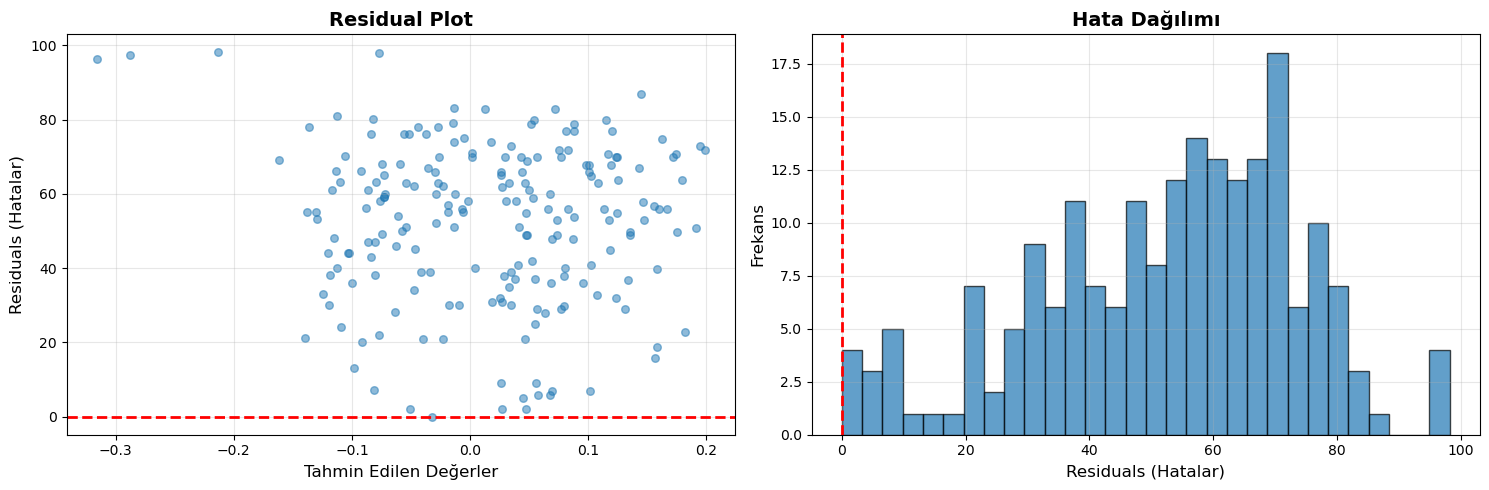

Ortalama Hata: 52.2995
Hata Standart Sapması: 21.1749


In [ ]:
# Residual (hata) analizi
residuals = y_test - y_pred.flatten()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Residual plot
axes[0].scatter(y_pred, residuals, alpha=0.5, s=30)
axes[0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Tahmin Edilen Değerler', fontsize=12)
axes[0].set_ylabel('Residuals (Hatalar)', fontsize=12)
axes[0].set_title('Residual Plot', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Hata dağılımı histogram
axes[1].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Residuals (Hatalar)', fontsize=12)
axes[1].set_ylabel('Frekans', fontsize=12)
axes[1].set_title('Hata Dağılımı', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Ortalama Hata: {np.mean(residuals):.4f}")
print(f"Hata Standart Sapması: {np.std(residuals):.4f}")

## Model Özeti ve Sonuçlar

### Neural Network Mimarisi:
- **4 Hidden Layer** (128 → 64 → 32 → 16 nöron)
- **Dropout Layers**: Overfitting önleme
- **Aktivasyon**: ReLU (hidden), Linear (output)
- **Optimizer**: Adam
- **Loss**: Mean Squared Error

### Performans Metrikleri:
Yukarıdaki metrikler modelin başarısını göstermektedir:
- **R² Score**: Modelin açıklama gücü (1'e yakın = iyi)
- **MAE**: Ortalama mutlak hata (düşük = iyi)
- **RMSE**: Kök ortalama kare hata (düşük = iyi)